In [24]:
# Import packages
%matplotlib inline
import matplotlib.pyplot as plt
from random import uniform, seed
import numpy as np
import pandas as pd
import csv
import time
from igraph import *
from functions_EX4 import *

In [25]:
with open('Highschool_network_edge.csv') as csvfile:
    reader = csv.reader(csvfile)
    edges = [(int(row[0][1:]), int(row[1][1:])) for row in reader]

NodeID = []
Gender = []
Hall = []
Threshold = []

with open('Highschool_network_att.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
        NodeID.append(int(row[0][1:]))
        Gender.append(row[1])
        Hall.append(row[2])
        Threshold.append(row[3])

g = Graph(edges, directed=False)

# g.vs["Gender"] = Gender
# g.vs["Hall"] = Hall
# g.vs["Threshold"] = Threshold

In [26]:
g = Graph(edges, directed=False)
g.delete_vertices(0)
# Number of components
g.vs["NodeID"] = NodeID
print("Number of components: ", g.vcount())


Number of components:  122


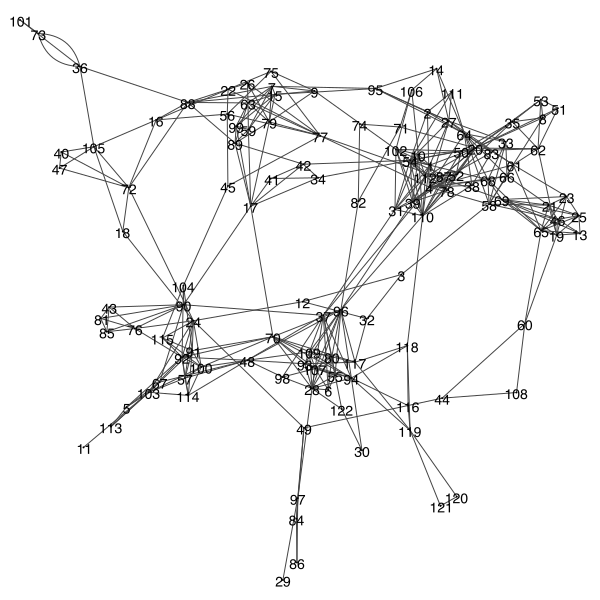

In [251]:
plot(g, bbox = (600,600), margin = 20, layout = g.layout("auto"), vertex_size = 1, vertex_color = "white", vertex_label = g.vs["NodeID"])


In [253]:
g.neighbors(106,mode="out")

[5, 27, 54, 69, 79, 92, 93, 95, 97, 108]

In [69]:
def IC_immunized(g, S, immunized, p=0.15, mc=1000, timestamps = 28):
    """
    Input:  
    g - graph object, 
    S - set of seed nodes(dtype list)
    immunized - set of immunized nodes(dtype list)
    p - propagation probability
    mc - the number of Monte-Carlo simulations
    timestamps - the number of timestamps

    Output: 
    - average number of nodes activated in each Monte-Carlo simulation
    - average number of nodes influenced by the seed nodes in each timestamp
    """
    
    # Loop over the Monte-Carlo Simulations
    spread, sum_spread, infected_a_day= [], [], []
    for i in range(mc):
        S = list(set(S).difference(set(immunized)))
        # Simulate propagation process
        Active = S[:]
        sum = 0
        infected_per_day = []
        for _ in range(timestamps):
            new_ones = []
            # For each active node, find its neighbors that become activated
            for node in Active:
                # np.random.seed(i)
                # Determine neighbors that become infected
                success = np.random.uniform(0,1, len(g.neighbors(node,mode="out"))) <= p
                new_ones += list(np.extract(success, g.neighbors(node,mode="out")))
                new_ones = list(set(new_ones).difference(set(immunized)))
                
            
            new_active = list(set(new_ones).difference(set(Active)))
            # print(new_active)
            # in case the network is fully activated
            # if new_active == []:
            #     break

            sum += len(Active) 
            infected_per_day.append(len(new_active))

            # Add newly activated nodes to the set of activated nodes
            Active = list(set(Active).union(set(new_active)))
            
        spread.append(len(Active))
        sum_spread.append(sum)
        infected_a_day.append(infected_per_day)
        
    return(np.mean(spread), np.mean(sum_spread), compute_mean_by_index(infected_a_day))

In [70]:
IC_immunized(g, [106], [], p = 0.15, mc = 10, timestamps = 28)

(121.9,
 2160.0,
 [1.1,
  3.3,
  4.1,
  4.6,
  6.2,
  7.3,
  9.2,
  10.3,
  7.8,
  9.4,
  9.4,
  9.2,
  8.8,
  6.7,
  6.6,
  4.7,
  4.1,
  3.1,
  1.0,
  1.4,
  0.8,
  0.4,
  0.3,
  0.3,
  0.5,
  0.1,
  0.1,
  0.1])

In [364]:
greedy_immunized(g, 3, 0.15, mc=100)

([95, 36, 69],
 [54.03, 33.98, 17.5],
 [8.702865839004517, 15.379617691040039, 19.651111841201782])

In [6]:
greedy(g, 3, 0.15, mc=600)

([0, 91, 18],
 [[20.595, 10.958333333333334],
  [25.30666666666667, 21.335],
  [27.765, 25.47833333333333]],
 [54.13395714759827, 133.87968516349792, 222.22429513931274])

# Question 19

In [7]:
def linear_threshold_model(G,threshold, seed_nodes=None,init_spread=True,max_iter=None):
    """
    Runs the linear threshold model on a grap_too
l graph G. S_i(t+1) = {1 if <s_j>i~j > T otherwise 0. If the average state of neighbours of i is more than the threshold T, switch the state from 0 to 1
    Takes inputs:
       G: Graph_tool graph
       threshold: float or list of the thresholds as a fraction of neighbors that need to be active to transmit
       seed_nodes: int or list of nodes to start infection from, if None a single random agent is choosen. If int, a number of random nodes is choosen, if a list of nodes those are the initial seeds.
       init_spread: Bool, Wether to spread the infection to the neighbors of seed nodes
       max_iter = maximum number of iterations before stopping. If all nodes in the graph are active the model will stop
    Returnd:
       infected_step: Graph_tool VertexPropertyMap with an interger denoting the step of activation for a given vertex, None if never activated. Velues are stored as vectors, with each index corresponding to a given threshold.
       seed_nodes: Graph_tool GraphProperty with the initail seed nodes for the model run
    """
    # get_vertices
    # graph_tool.spectral.adjacency
    # G.new_vp
    # gt.group_vector_property(infections)


    if seed_nodes == None:
        [seed_nodes for x in np.random.choice(G.get_vertices(),1)]

    if not type(seed_nodes) is list:
        seed_nodes = np.random.choice(G.get_vertices(),seed_nodes)

    if max_iter is None:
        max_iter = G.vcount()
        
    if not type(threshold) is list:
        [threshold]

    infections = []
    degree_dist = G.get_out_degrees(G.get_vertices())

    T = np.array((g.get_adjacency().T / degree_dist).T)  

    for th in threshold:
        # Choose the initial infected nodes
        infected = np.zeros(G.num_vertices(),dtype=int)
        infection_step = np.full(G.num_vertices(),np.inf,dtype=float)
        node_list = np.arange(G.num_vertices(),dtype=int)
        
        #Infect the seed nodes
        infected[seed_nodes] = 1
        #Record seed nodes infected at t=-1
        infection_step[seed_nodes] = -1

        #Initial spread, if choosen
        if init_spread:
            infected[T.dot(infected) > 0] = 1
            infection_step[np.logical_and(infected > 0, np.isinf(infection_step))] = 0
            i = 1
        else:
            i = 0

        while (not all(infected) and (i < max_iter) and i-1 in infection_step):
            infected[T.dot(infected) >= th] = 1
            infection_step[np.logical_and(infected > 0, np.isinf(infection_step))] = i

            i += 1
        
        infected_step = G.new_vp(value_type='int',vals=infection_step)
        infections.append(infected_step)
        
    
    infected_vectormap = gt.group_vector_property(infections)
    # G.vp['infected_step'] = infected_vectormap    
    threshold_vector = G.new_gp(value_type='vector<double>',val=threshold)

In [18]:
linear_threshold_model(g,0.5,seed_nodes=107,init_spread=True,max_iter=100)

AttributeError: 'Graph' object has no attribute 'get_vertices'

In [16]:
arr = np.array(g.get_adjacency()).T

In [18]:
arr

array(Matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 